In [1]:

import tempfile
import pickle as pkl
from pathlib import Path
import os
import yaml

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

import mlflow

from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import GPT2Tokenizer

import shap

from auxiliar import crear_ensemble_donadas

In [2]:
# Paramètres
with open("config.yml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

INPUT_FICHIER_WIKI_TEXTE = config['camins']['texte']['fichier_wiki_texte']
INPUT_FICHER_WIKI_ETIQUETAS_MANUAL = config['camins']['etiquetas']['fichier_wiki_etiquetas_manual']
INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC = config['camins']['etiquetas']['fichier_wiki_etiquetas_automatic']
INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA = config['camins']['etiquetas']['fichier_wiki_etiquetas_entropia']
INPUT_DORSIER_TOKENIZAIRE = config['camins']['tokenizaire']['dossier_tokenizaire']

OUTPUT_PREDICCIONS = config['camins']['classificador']['prediccions']
OUTPUT_SELECCION_PAGINAS = config['camins']['classificador']['seleccion_paginas']
OUTPUT_DORSIER_MODEL = config['camins']['classificador']['dossier_model']

OPTIMIZACION_BAYESIANA = False

In [3]:
texte_df = pd.read_csv(INPUT_FICHIER_WIKI_TEXTE)

texte_etiquetas_df = crear_ensemble_donadas(
    texte_df=texte_df,
    lista_dialectes_df=[
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_MANUAL),
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC),
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA),
    ],
)
texte_etiquetas_df

,Article,Dialecte,Texte
0,Vieux-Champagne,lengadocian,vieux-champagne es una situada dins lo de sèin...
1,Ereditat,lengadocian,lereditat (del latin hereditas çò que s'erita ...
2,White_Town,lengadocian,white town es un projècte britanic de musica e...
3,Puigverd_d'Agramunt,lengadocian,puigverd d'agramunt es un de la
4,La_Grande_Montagne,lengadocian,la grande montagne es una de sant bartomieu di...
...,...,...,...
8308,Coduras,gascon,coduras
8309,Cobluc,gascon,cobluc
8310,Michal_Kováč,lengadocian,michal ková banquièr e òme politic (ubia 5 d'a...
8311,La_Bruguièra_Dorçan,lengadocian,la bruguièra dorçan


In [4]:
texte_etiquetas_entrenament, texte_etiquetas_test = train_test_split(texte_etiquetas_df, test_size=0.2)

In [5]:
# Crear sac a mots
tokenizaire = GPT2Tokenizer.from_pretrained(
    INPUT_DORSIER_TOKENIZAIRE,
    do_lower_case=True,
)
tokens_entrenament = texte_etiquetas_entrenament["Texte"].apply(tokenizaire.tokenize).apply(lambda x: ' '.join(x))
tokens_test = texte_etiquetas_test["Texte"].apply(tokenizaire.tokenize).apply(lambda x: ' '.join(x))
tokens_tot = texte_df["Texte"].apply(tokenizaire.tokenize).apply(lambda x: ' '.join(x))

vectorizador = CountVectorizer()
bow_entrenament = vectorizador.fit_transform(tokens_entrenament)
bow_test = vectorizador.transform(tokens_test)
bow_tot = vectorizador.transform(tokens_tot)

# Codificar los dialèctes
codificador_ordinal = OrdinalEncoder()
etiquetas_entrenament = codificador_ordinal.fit_transform(texte_etiquetas_entrenament[["Dialecte"]]).astype(int)
etiquetas_test = codificador_ordinal.transform(texte_etiquetas_test[["Dialecte"]]).astype(int)

In [6]:
melhor_params = {}
if OPTIMIZACION_BAYESIANA:
    def evaluar(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        kf = KFold(n_splits=3)
        f1_scores = []

        for train_index, valid_index in kf.split(bow_entrenament):
            
            xgb = XGBClassifier(
                max_depth=int(max_depth),
                learning_rate=learning_rate,
                n_estimators=int(n_estimators),
                gamma=gamma,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
            )
            xgb.fit(
                bow_entrenament[train_index],
                etiquetas_entrenament[train_index],
                sample_weight=compute_sample_weight("balanced", etiquetas_entrenament[train_index]),
                verbose=False,
            )
            etiquetas_predichas = xgb.predict(bow_entrenament[valid_index])
            score = f1_score(etiquetas_entrenament[valid_index], etiquetas_predichas, average="macro")
            f1_scores.append(score)

        return np.mean(f1_scores)


    limits = {
        "max_depth": (3, 12),
        "learning_rate": (0.01, 0.5),
        "n_estimators": (50, 200),
        "gamma": (0, 0.5),
        "min_child_weight": (1, 10),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
    }

    optimizaire = BayesianOptimization(f=evaluar, pbounds=limits, random_state=63, verbose=2)

    optimizaire.maximize(init_points=10, n_iter=20)

    melhor_params = optimizaire.max["params"]
    melhor_params["max_depth"] = int(melhor_params["max_depth"])
    melhor_params["n_estimators"] = int(melhor_params["n_estimators"])

Exactitud: 0.9326518340348767
Precision: 0.8063365498410161
Rappel: 0.8327858106805475
F1: 0.817077390414764


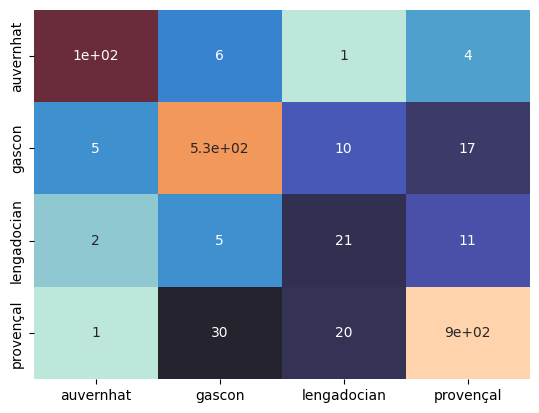

In [7]:
# Initialize MLflow
mlflow.set_experiment("XGBoost")
os.makedirs("mlruns", exist_ok = True) 

# Start an MLflow run
with mlflow.start_run():

    # Entrenar e gardar lo darrièr model
    xgb_final = XGBClassifier(
        **melhor_params,
    )

    xgb_final.fit(
        bow_entrenament,
        etiquetas_entrenament,
        sample_weight=compute_sample_weight("balanced", etiquetas_entrenament),
    )
    for nom_param, valor_param in melhor_params.items():
        mlflow.log_param(nom_param, valor_param)

    # Predire e evaluar lo model
    y_pred_test = xgb_final.predict(bow_test).reshape(-1, 1)

    # Transformar las etiquetas numericas en etiquetas textualas
    dialecte_obs_test = codificador_ordinal.inverse_transform(etiquetas_test)
    dialecte_pred_test = codificador_ordinal.inverse_transform(y_pred_test)

    # Exactitud, Precision, Rappel, F1
    exactitud = accuracy_score(dialecte_obs_test, dialecte_pred_test)
    precision, rappel, f1, _ = precision_recall_fscore_support(
        dialecte_obs_test,
        dialecte_pred_test,
        average="macro",
    )
    print(f"Exactitud: {exactitud}\nPrecision: {precision}\nRappel: {rappel}\nF1: {f1}")
    mlflow.log_metric("exactitud", exactitud)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("rappel", rappel)
    mlflow.log_metric("f1", f1)

    # Matritz de confusion
    matritz_confusion = confusion_matrix(dialecte_obs_test, dialecte_pred_test)
    matritz_confusion_df = pd.DataFrame(
        matritz_confusion,
        index=codificador_ordinal.categories_[0],
        columns=codificador_ordinal.categories_[0],
    )
    fig = sns.heatmap(np.log(matritz_confusion_df + 1), annot=matritz_confusion_df, cbar=None, cmap="icefire")
    with tempfile.NamedTemporaryFile(suffix='.png') as temp_file:
        plt.savefig(temp_file.name)
        mlflow.log_artifact(temp_file.name, artifact_path="images")


In [8]:
with open(Path(OUTPUT_DORSIER_MODEL) / Path('vectorizador.pkl'), 'wb') as f:
    pkl.dump(vectorizador, f)

with open(Path(OUTPUT_DORSIER_MODEL) / Path('codificador_ordinal.pkl'), 'wb') as f:
    pkl.dump(codificador_ordinal, f)

with open(Path(OUTPUT_DORSIER_MODEL) / Path('classificador.pkl'), 'wb') as f:
    pkl.dump(xgb_final, f)

In [9]:
# Generar prediccions per totes los articles
y_pred_tot = xgb_final.predict(bow_tot).reshape(-1, 1)
y_prob_tot = xgb_final.predict_proba(bow_tot)
entropia_tot = np.sum(-y_prob_tot * np.log(y_prob_tot), axis=1)
resultats_df = pd.DataFrame(
    {
        "Article": texte_df["Article"],
        "Prediccion": codificador_ordinal.inverse_transform(y_pred_tot).reshape(-1),
        "Entropia": entropia_tot.reshape(-1),
    }
)
resultats_df = pd.concat(
    [resultats_df, pd.DataFrame(y_prob_tot, columns=codificador_ordinal.categories_[0])],
    axis=1,
)
resultats_df = resultats_df.merge(texte_etiquetas_df[["Article", "Dialecte"]], on="Article", how="left")
resultats_df.to_csv(OUTPUT_PREDICCIONS, index=False)
resultats_df.sort_values("Entropia", ascending=False)["Article"].to_csv(
    OUTPUT_SELECCION_PAGINAS, index=False, header=False
)
resultats_df.sort_values("Entropia", ascending=False)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
69508,La_Ròca_d'Òlmes,auvernhat,1.385219,2.680954e-01,0.236183,2.504872e-01,0.245234,NaN
55389,Odontoceti,lengadocian,1.384686,2.388607e-01,0.234064,2.690878e-01,0.257987,NaN
40701,Ar_Merzher-Salaun,lengadocian,1.384481,2.323803e-01,0.254133,2.724600e-01,0.241027,NaN
41601,Charmois_(Territòri_de_Belfòrt),gascon,1.383379,2.453659e-01,0.277337,2.533469e-01,0.223950,NaN
49730,Cementèri_nuclear,provençal,1.382716,2.160888e-01,0.256381,2.542660e-01,0.273264,NaN
...,...,...,...,...,...,...,...,...
69623,Gorg_d'Esparròs,gascon,0.000037,7.627472e-08,0.999997,2.175545e-07,0.000002,NaN
31843,Guèrras_Arabobizantinas,provençal,0.000036,3.448593e-07,0.000002,5.397262e-07,0.999998,provençal
5914,Sent_Estève_(Arberoa),gascon,0.000035,4.941144e-07,0.999998,8.229889e-07,0.000001,gascon
29607,Mandolina,gascon,0.000035,8.119757e-07,0.999998,4.664679e-07,0.000001,gascon


<Axes: xlabel='Prediccion', ylabel='Entropia'>

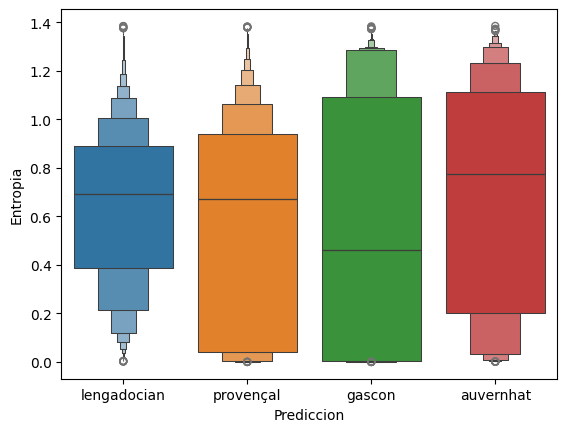

In [10]:
sns.boxenplot(data=resultats_df, x="Prediccion", y="Entropia", hue="Prediccion")

In [11]:
resultats_df.query('Dialecte.isnull() & Prediccion == "lengadocian"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
55389,Odontoceti,lengadocian,1.384686,0.238861,0.234064,0.269088,0.257987,NaN
40701,Ar_Merzher-Salaun,lengadocian,1.384481,0.232380,0.254133,0.272460,0.241027,NaN
36153,Dent,lengadocian,1.379337,0.247778,0.234390,0.298694,0.219138,NaN
7955,Regim_cevenòl_(idrologia),lengadocian,1.378644,0.227726,0.221918,0.301557,0.248799,NaN
34299,Peirussa_(Auvèrnhe),lengadocian,1.376453,0.251852,0.215540,0.307188,0.225420,NaN
75606,Cercle_Occitan_deu_sud_Gironda,lengadocian,1.375462,0.279930,0.200176,0.289580,0.230314,NaN
65296,Dakota_(lingüistica),lengadocian,1.369615,0.277031,0.263743,0.284375,0.174852,NaN
52149,Sarrasac_(Carcin),lengadocian,1.368072,0.193304,0.275222,0.314615,0.216860,NaN
42275,La_Méaugon,lengadocian,1.368013,0.212523,0.260805,0.324616,0.202057,NaN
56212,Matèu_Bloin,lengadocian,1.367814,0.209240,0.289704,0.305052,0.196005,NaN


In [12]:
resultats_df.query('Dialecte.isnull() & Prediccion == "auvernhat"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
69508,La_Ròca_d'Òlmes,auvernhat,1.385219,0.268095,0.236183,0.250487,0.245234,NaN
41487,Acropòli_d'Atenas,auvernhat,1.373288,0.283928,0.281378,0.186312,0.248382,NaN
46644,Lengas_samba-duru,auvernhat,1.372092,0.299268,0.238564,0.273699,0.188469,NaN
51939,Sòfia,auvernhat,1.369694,0.291817,0.259675,0.176260,0.272248,NaN
69188,Hebe_Camargo,auvernhat,1.369526,0.307350,0.211298,0.281990,0.199363,NaN
3978,Thonne-les-Près,auvernhat,1.366179,0.329887,0.190682,0.229582,0.249848,NaN
56139,Abril_de_2006,auvernhat,1.363559,0.290051,0.269584,0.162608,0.277757,NaN
66747,Fiona_Apple,auvernhat,1.363041,0.316980,0.231997,0.276966,0.174057,NaN
82361,Lengas_palaihnihanas,auvernhat,1.362232,0.320362,0.188956,0.204757,0.285925,NaN
6847,Ebersmunster,auvernhat,1.360508,0.322198,0.269070,0.241110,0.167622,NaN


In [13]:
texte_etiquetas_df.groupby("Dialecte")["Article"].count()

Dialecte
auvernhat       514
gascon         2855
lengadocian     164
provençal      4780
Name: Article, dtype: int64

In [14]:
resultats_df.groupby("Prediccion")["Article"].count()

Prediccion
auvernhat       1615
gascon         13374
lengadocian    47904
provençal      22652
Name: Article, dtype: int64

In [16]:
# explicador = shap.TreeExplainer(xgb_final)
# shap_df = pd.DataFrame(explicador(bow_test), index=texte_etiquetas_test["Article"], columns=vocab_list)

In [17]:
fi_df = pd.DataFrame({"FI": xgb_final.feature_importances_})
fi_df["TokenIndex"] = list(range(0, fi_df.shape[0]))
fi_df["Token"] = fi_df["TokenIndex"].map(lambda x: vocab[x])
fi_df.sort_values('FI', ascending=False).head(60)

,FI,TokenIndex,Token
17206,0.086528,17206,ġua
9620,0.062437,9620,ġdei
2196,0.032218,2196,es
9900,0.030165,9900,ġdeu
15525,0.021598,15525,ġreferences
12747,0.021012,12747,ġlingã¼istica
12620,0.019664,12620,ġlei
9526,0.017557,9526,ġdau
11868,0.012493,11868,ġho
9396,0.010991,9396,ġcrotz
